In [1]:
import scipy
from scipy.integrate import dblquad
import numpy as np
from jax import jit, vmap
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.numpy.linalg import norm
from tqdm.notebook import tqdm

from opt_methods import one_pass_sgd, one_pass_adam, risk

In [2]:
@jit
def risk(K,x,target):
    return (x - target).transpose() @ K @ (x - target) / 2

def risk_from_B_linreg(B, key = None):
    return (B[0,0] + B[1,1] - 2 * B[0,1]) / 2

def risk_from_B_logreg(B, key, num_samples = 5000):
    z_key, w_key = jax.random.split(key)
    z = jax.random.normal(z_key, (num_samples,))
    w = jax.random.normal(w_key, (num_samples,))
    
    exp_gau1 = jnp.exp(jnp.sqrt(B[1,1]) * z)
    exp_gau2 = jnp.exp(jnp.sqrt(B[0,0]) * w)
    return - B[0,1] * (exp_gau1 / (1 + exp_gau1)**2 - jnp.log(exp_gau2 + 1)).mean()

##### "non-asymptotic" version
# @jit
# def mean_func(z1, z2, beta, Pbeta, P):
#     return z1**2 * z2**2 / jnp.sqrt(2 * beta * Pbeta + (1-beta) * 2 * P * z1**2 * z2**2)

# @jit
# def cov_func(z1, z2, beta, Pbeta, P):
#     return z1**2 * z2**2 / (2 * beta * Pbeta + (1-beta) * 2 * P * z1**2 * z2**2)

# @jit
# def mean_func(z1, z2, beta, Pbeta, P):
#     return z1**2 * z2**2 / jnp.sqrt(2 * beta * Pbeta + (1-beta) * 2 * P * z1**2 * z2**2)

# @jit
# def cov_func(z1, z2, beta, Pbeta, P):
#     return z1**2 * z2**2 / (2 * beta * Pbeta + (1-beta) * 2 * P * z1**2 * z2**2)


# ##### "Asymptotic" version as Pbeta -> P
# # @jit
# # def mean_func(z1, z2, beta, Pbeta, P):
# #     return z1**2 * z2**2 / jnp.sqrt( 2 * P * (beta + (1-beta) * z1**2 * z2**2)) 

# # @jit
# # def cov_func(z1, z2, beta, Pbeta, P):
# #     return z1**2 * z2**2 / (2 * P * (beta + (1-beta) * z1**2 * z2**2))

# @jit
# def mean_discount(beta, Pbeta, P, key, num_samples=10000):
#     # Sample z1 and z2 from a standard normal distribution
#     key1, key2 = jax.random.split(key)
#     z1_samples = jax.random.normal(key1, (num_samples,))
#     z2_samples = jax.random.normal(key2, (num_samples,))

#     # Compute the integrand for each sample pair
#     integrand_values = vmap(lambda z1, z2: mean_func(z1, z2, beta, Pbeta, P))(z1_samples, z2_samples)

#     # Monte Carlo estimate of the integral
#     return jnp.mean(integrand_values)

# @jit
# def cov_discount(beta, Pbeta, P, key, num_samples=10000):
#     # Sample z1 and z2 from a standard normal distribution
#     key1, key2 = jax.random.split(key)
#     z1_samples = jax.random.normal(key1, (num_samples,))
#     z2_samples = jax.random.normal(key2, (num_samples,))

#     # Compute the integrand for each sample pair
#     integrand_values = vmap(lambda z1, z2: cov_func(z1, z2, beta, Pbeta, P))(z1_samples, z2_samples)

#     # Monte Carlo estimate of the integral
#     return jnp.mean(integrand_values)

In [3]:
# def adam_ode(K, Kbar, T, x0, xstar, lr, beta, noise_std):
#     print('Precomputations...')

#     # Perform the diagonalization
#     d = K.shape[0]
    
#     eigs, L = jnp.linalg.eig(Kbar)
#     R = jnp.linalg.inv(L).T
#     eigs, L, R = jnp.real(eigs), jnp.real(L), jnp.real(R)

#     # Setup the ODE system
#     v0 = x0 - xstar    
#     var_force = eigs**2
#     r = jnp.array([jnp.inner(v0, K @ L[:,j]) * jnp.inner(R[:,j], v0) for j in range(d)]) / 2
        
#     # Setup jax rng
#     key = jax.random.PRNGKey(0)
#     key_mean, key_cov = jax.random.split(key)        
    
#     risks = []
#     d = len(x0)
#     dt = 1/d

#     ode_time = []
#     iters = int(T / dt)

#     print('Iterating...')
#     Pbeta = 0
#     Pbetas = []
#     for i in tqdm(range(iters)):
#         t = i * dt
#         R = jnp.sum(r)
#         P = R + noise_std**2/2
#         ode_time.append(t)
#         risks.append(R)
        
#         Pbetas.append(Pbeta)
#         key_mean, subkey_mean = jax.random.split(key_mean)
#         key_cov, subkey_cov = jax.random.split(key_cov)
        
#         update = -lr * 2 * r * eigs * mean_discount(beta, Pbeta, P, subkey_mean) + lr**2 * P * cov_discount(beta, Pbeta, P, subkey_cov) * var_force / d        

#         Pbeta = beta * Pbeta + (1-beta) * P ## This is the truth
                
#         # Pbeta = 15*jnp.cos(i)**2 ## This is to test things
#         # Pbeta = 0 ## This is to test things
        
#         r = r + dt * update

       
    
#     return jnp.array(risks), jnp.array(ode_time), jnp.array(Pbetas)

        
def one_pass_adam(quadratic, grad_function, K, data, targets, params0, optimal_params, lrk, beta1, beta2):
        
    def update(carry, idx):
        params, m, v, Pbeta, quad_vals, step, Vs = carry
        data_point, target = data[idx], targets[idx]
        
        Q = quadratic(K,params,optimal_params)
        Vs = Vs.at[step].set(v)
        quad_vals = quad_vals.at[step].set(Q)
        # Pbetas = Pbetas.at[step].set(Pbeta)   
        
        # Compute gradient
        grad = grad_function(params, data_point, target)

        # Update moment estimates
        m = beta1 * m + (1 - beta1) * grad        
        v = beta2 * v + (1 - beta2) * grad**2

        # Bias correction
        # mhat = m / (1 - beta1 ** (step + 1))
        # vhat = v / (1 - beta2 ** (step + 1))
        
        ## This is the truth
        mhat = m
        vhat = v ## This is the truth
        # vhat = 2 * beta2 * Pbeta * jnp.diag(K)  + (1 - beta2) * grad**2 ## This is to test things
        
        # This is to test things
        # vhat = beta2 * jnp.diag(K) * 4  + (1 - beta2) * grad**2
        # Pbeta = 15*jnp.cos(step)**2
        # Pbeta = 0
        # Q = quadratic(K,params,optimal_params)

        # Compute update step
        eps = 0
        step_update = mhat / (jnp.sqrt(vhat) + eps)

        # Update params
        params = params - lrk * step_update
        Pbeta = beta2 * Pbeta + (1 - beta2) * Q
                
        return (params, m, v, Pbeta, quad_vals, step + 1, Vs), None

    # Preallocate arrays for risk_vals, times, Pbetas, and Vs
    max_steps = len(data)
    quad_vals = jnp.zeros(max_steps)
    times = jnp.arange(max_steps)    
    Vs = jnp.zeros((len(data), K.shape[0]))

    # Initialize variables
    d = K.shape[0]
    m = jnp.zeros(d)
    v = jnp.zeros(d)
    Pbeta = 0
    
    carry = (params0, m, v, Pbeta, quad_vals, 0, Vs)

    # Use JAX lax.scan for iteration
    carry, _ = jax.lax.scan(update, carry, times)

    params, m, v, Pbeta, quad_vals, step, Vs = carry

    return quad_vals, times


In [4]:
from functools import partial
import jax

# @partial(jax.jit, static_argnames=['f'])
# def adam_mean_from_params(params, optimal_params, f, K, Kbar, beta, fk, other, key, n_samples = 10000):
#     """
#     Compute the mean of the adam update in terms of parameters 
#     TODO: Document this better    
#     """
        
#     B = jnp.array([[params.T @ K @ params, optimal_params.T @ K @ params],[optimal_params.T @ K @ params, optimal_params.T @ K @ optimal_params]])
#     Binv = jnp.linalg.inv(B)
#     key_Q, key_z = jax.random.split(key)
    
    
#     Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=n_samples)
#     z = jax.random.normal(key_z, (n_samples,))
#     fq = f(Q)
    
#     mean_fq = fq.mean()    
#     phi = jnp.mean((z**2 * fq / jnp.sqrt(beta*fk + beta*other + (1-beta) * fq**2 * z**2))[:,None]  *  (Q @ Binv), axis = 0)
    
    
#     return Kbar @ params * phi[0] + Kbar @ optimal_params * phi[1], mean_fq

def phi_from_B(B, f, beta,  key, n_samples = 10000):
    """
    Compute the mean of the adam update in terms of B
    TODO: Document this better    
    """
    
    Binv = jnp.linalg.inv(B)
    key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)

    history_length = 50
    # Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
    Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, 1))
    z = jax.random.normal(key_z, (n_samples))

    if beta > 0:
        Q_history = jax.random.multivariate_normal(key_Q_hist, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
        z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

        decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
        history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
    else:
        history_average = 0

    fq = f(Q)
    fq = fq.squeeze()
    Q = Q.squeeze()
        
    phi = jnp.mean((z**2 * fq / jnp.sqrt( history_average + (1-beta) * fq**2 * z**2))[:,None]  *  (Q @ Binv), axis = 0)
        
    return phi

def cov_from_B(B, f, beta,  key, n_samples = 10000):
    """
    Compute the covariance update the adam update in terms of B
    TODO: Document this better    
    """
        
    key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)

    history_length = 50
    # Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
    Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, 1))
    z = jax.random.normal(key_z, (n_samples))

    if beta > 0:        
        Q_history = jax.random.multivariate_normal(key_Q_hist, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
        z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

        decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
        history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
    else:
        history_average = 0

    fq = f(Q)
    fq = fq.squeeze()        
    
    return jnp.mean(z**2 * fq**2 / (history_average + (1-beta) * fq**2 * z**2))



def adam_mean_from_params(params, optimal_params, f, K, Kbar, beta,  key, n_samples = 10000):
    """
    Compute the mean of the adam update in terms of parameters 
    TODO: Document this better    
    """
        
    B = jnp.array([[params.T @ K @ params, optimal_params.T @ K @ params],[optimal_params.T @ K @ params, optimal_params.T @ K @ optimal_params]])
    Binv = jnp.linalg.inv(B)
    key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)


    history_length = 50
    # Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
    Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, 1))
    z = jax.random.normal(key_z, (n_samples))

    if beta > 0:
        Q_history = jax.random.multivariate_normal(key_Q_hist, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
        z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

        decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
        history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
    else:
        history_average = 0

    fq = f(Q)
    fq = fq.squeeze()
    Q = Q.squeeze()
        
    phi = jnp.mean((z**2 * fq / jnp.sqrt( history_average + (1-beta) * fq**2 * z**2))[:,None]  *  (Q @ Binv), axis = 0)
        
    return Kbar @ params * phi[0] + Kbar @ optimal_params * phi[1]
    


def adam_cov_from_params_diag(params, optimal_params, f, K, beta, key, n_samples = 10000):
    """
    Compute the mean of the adam update in terms of parameters 
    TODO: Document this better
    """
    B = jnp.array([[params.T @ K @ params, optimal_params.T @ K @ params],[optimal_params.T @ K @ params, optimal_params.T @ K @ optimal_params]])    
    key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)


    history_length = 50
    # Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
    Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, 1))
    z = jax.random.normal(key_z, (n_samples))

    if beta > 0:        
        Q_history = jax.random.multivariate_normal(key_Q_hist, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
        z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

        decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
        history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
    else:
        history_average = 0

    fq = f(Q)
    fq = fq.squeeze()        
    
    return jnp.mean(z**2 * fq**2 / (history_average + (1-beta) * fq**2 * z**2))
        
        
def adam_sde_diag(quadratic, f,  T, lr, K, Kbar, beta, params0, optimal_params, d, key = None):
    # dt = 0.001
    dt = 1/d
    sqrtdt = np.sqrt(dt)
            
    steps = int(T / dt)
    params = params0
    Q = quadratic(K, params, optimal_params)
    quad_vals = [Q]
    if key is None:
        key = jax.random.PRNGKey(0)
            
    key_mean, key_cov, key_brownian = jax.random.split(key, 3)
            
    for _ in range(steps):
        # W = np.random.randn(d) * sqrtdt       
        key_brownian, subkey_brownian = jax.random.split(key_brownian)
        W = jax.random.normal(subkey_brownian, (d,)) * sqrtdt

        key_mean, subkey_mean = jax.random.split(key_mean)
        key_cov, subkey_cov = jax.random.split(key_cov)        
                        
        mean = adam_mean_from_params(params, optimal_params, f, K, Kbar, beta, subkey_mean)
        cov = adam_cov_from_params_diag(params, optimal_params, f, K, beta, subkey_cov)
                                                        
        params = params - lr * mean * dt + lr * jnp.sqrt(cov) * W / jnp.sqrt(d)
                
        Q = quadratic(K, params, optimal_params)                
        quad_vals.append(Q)
    
    times = jnp.array(range(steps + 1)) * dt
    return jnp.array(quad_vals), times


In [5]:
def adam_ode(K, Kbar, T, params0, optimal_params, lr, beta, f, risk_from_B):
    print('Precomputations...')

    # Perform the diagonalization
    d = K.shape[0]

    eigs, L = jnp.linalg.eig(Kbar)
    R = jnp.linalg.inv(L).T
    eigs, L, R = jnp.real(eigs), jnp.real(L), jnp.real(R)

    # Setup the ODE systems 
    var_force = jnp.array([jnp.inner(R[:, j], K @ L[:, j]) for j in range(len(K))])
    p = jnp.array([jnp.inner(params0, K @ L[:,j]) * jnp.inner(R[:,j], params0) for j in range(d)])
    u = jnp.array([jnp.inner(params0, K @ L[:,j]) * jnp.inner(R[:,j], optimal_params) for j in range(d)])
    v = jnp.array([jnp.inner(optimal_params, K @ L[:,j]) * jnp.inner(R[:,j], params0) for j in range(d)])
    q = jnp.array([jnp.inner(optimal_params, K @ L[:,j]) * jnp.inner(R[:,j], optimal_params) for j in range(d)])

        
    B11 = jnp.sum(p)
    B12 = jnp.sum(u)
    B21 = jnp.sum(v)
    B22 = jnp.sum(q)
    
    
    # Setup jax rng
    key = jax.random.PRNGKey(0)
    key_mean, key_cov, key_risk = jax.random.split(key, 3)

    risks = []
    dt = 1/d

    ode_time = []

    iters = int(T / dt)
    Bs = []
    print('Iterating...')
    for i in tqdm(range(iters)):
        key_mean, subkey_mean = jax.random.split(key_mean)
        key_cov, subkey_cov = jax.random.split(key_cov)
        key_risk, subkey_risk = jax.random.split(key_risk)
        
        t = i * dt
        ode_time.append(t)
        
        
        
        B11 = jnp.sum(p)
        B12 = jnp.sum(u)
        B21 = jnp.sum(v)
        B22 = jnp.sum(q)
        B = jnp.array([[B11,B12],[B21,B22]])
        
        R = risk_from_B(B, subkey_risk)
                
        risks.append(R)
        Bs.append(B)
                        
        
        phi1_B, phi2_B = phi_from_B(B, f, beta, subkey_mean)
        
        
        p_update = -lr * eigs * (2* p* phi1_B + phi2_B * (u + v))
        p_update += lr**2 * cov_from_B(B, f, beta, subkey_cov) * var_force / d
        # p_update += lr**2 * 1 * var_force / d        
                
        u_update = -lr * eigs * (phi1_B * u + phi2_B * q)
        v_update = -lr * eigs * (phi1_B * v + phi2_B * q)
                        
        p = p + dt * p_update
        u = u + dt * u_update
        v = v + dt * v_update


    return jnp.array(risks), jnp.array(ode_time), jnp.array(Bs)


# Run experiments 

In [6]:
## Set hyperparameters
d = 500
T = 8
n = int(T * d)


lr = 0.3 # large dimension limit lr 
lrk = lr / d   # effective lr

beta1 = 0
beta2 = 0.5
# Pbeta = 0.1

# targets and init


x0 = jnp.ones(d)
x0 /= norm(x0)

# xstar = jnp.zeros(d)
xstar = jnp.linspace(0.1,2,d)
xstar /= norm(xstar)

noise_std = 0.

K = jnp.diag(jnp.linspace(0.01, 1.5, d))
# K = np.eye(d)
Kbar = jnp.sqrt(K)

In [7]:
num_runs = 20
run_data = []
Vs_data = []

# @jax.jit
# def f_linreg(r):
#     r1 = r[:,0]
#     r2 = r[:,1]
#     return r1 - r2
from jax.nn import sigmoid as sig

def logreg(data, theta):
    logits = jnp.dot(data, theta)  
    probabilities = sig(logits)
    return probabilities

def grad_logreg(theta, data, target):
    p_student = logreg(data, theta)
    return (p_student - target) * data

@jit
def f_logreg(r):
    r1 = r[:,:,0]
    r2 = r[:,:,1]
    return sig(r1) - sig(r2)

@jax.jit
def f_linreg(r):
    r1 = r[:,:,0]
    r2 = r[:,:,1]
    return r1 - r2

def grad_linreg(theta, data, target):
    return (jnp.inner(data, theta) - target) * data

sde_vals_all_linreg = []


seed = np.random.randint(100)
key = jax.random.key(seed)
for i in tqdm(range(num_runs)):
    # data = np.random.randn(n,d)
   
    key, sub1, sub2 = jax.random.split(key, num = 3)
    data = jax.random.multivariate_normal(sub1, mean=jnp.zeros(d), cov=K, shape=(n,))
    eps = jax.random.normal(sub2, shape=(n,)) * noise_std
    
    # targets = data @ xstar - eps # for linear regression
    targets = logreg(data, xstar)  # for student-teacher logistic regression targets
    
    adam_risk, adam_time = one_pass_adam(risk, grad_logreg, K, data, targets, x0, xstar,lrk,beta1,beta2)
    # adam_risk, adam_time = one_pass_adam(risk, grad_linreg, K, data, targets, x0, xstar,lrk,beta1,beta2)
    key = jax.random.PRNGKey(np.random.randint(0, 10000))
    
    sde_vals, sde_times = adam_sde_diag(risk, f_logreg, T, lr, K, Kbar, beta2, x0, xstar, d, key=key)
    # sde_vals, sde_times = adam_sde_diag(risk, f_linreg, T, lr, K, Kbar, beta2, x0, xstar, d, key=key)
    # Vs_data.append(Vs)
    run_data.append(adam_risk)
    sde_vals_all_linreg.append(sde_vals)



sde_vals_all_linreg = jnp.array(sde_vals_all_linreg)  # Shape: (num_runs, num_steps)    
run_data = jnp.array(run_data)
# Vs_data = jnp.array(Vs_data)

adam_risk, ode_time, Bs = adam_ode(K, Kbar, T, x0, xstar, lr, beta2, f_logreg, risk_from_B_logreg)
# adam_risk, ode_time, Bs = adam_ode(K, Kbar, T, x0, xstar, lr, beta2, f_linreg, risk_from_B_linreg)

  0%|          | 0/20 [00:00<?, ?it/s]

Precomputations...
Iterating...


  0%|          | 0/4000 [00:00<?, ?it/s]

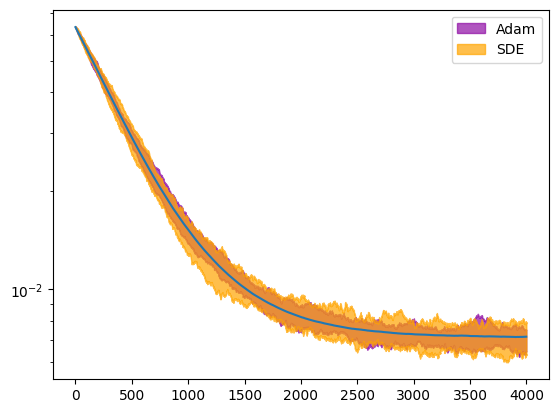

In [8]:
#### Set colormap and colors
cmap = 'plasma'

sgd_color = plt.get_cmap(cmap)(0.3)
hsgd_color = plt.get_cmap(cmap)(0.9)
ode_color = plt.get_cmap(cmap)(1)


#### Compute the quantiles
confidence = 0.8
q_low = (1-confidence)/2
q_high = 1/2 + confidence/2

adam_low = np.quantile(run_data,q_low,axis = 0)
adam_high = np.quantile(run_data,q_high,axis = 0)

sde_low = np.quantile(sde_vals_all_linreg,q_low,axis = 0)
sde_high = np.quantile(sde_vals_all_linreg,q_high,axis = 0)

# plt.yscale('log')
# plt.xscale('log')

# print(adam_high[-1])
# print(adam_high[100])
# print(adam_high[200])

plt.yscale('log')

plt.fill_between(adam_time, adam_low, adam_high, color= sgd_color, alpha=0.7, label = 'Adam')
plt.fill_between(sde_times * d, sde_low, sde_high, color= 'orange', alpha=0.7, label = 'SDE')
# plt.plot(ode_time * d, adam_risk)
plt.plot(ode_time * d, ((Bs[:,0,0] + Bs[:,1,1] - 2*Bs[:,0,1])/2))
# plt.xlim([0,200])
plt.legend()
plt.show()


In [9]:
((Bs[:,0,0] + Bs[:,1,1] - 2*Bs[:,0,1])/2)

Array([0.06329858, 0.06320101, 0.0631007 , ..., 0.00716734, 0.0071677 ,
       0.00716794], dtype=float32)

In [10]:
Bs[:,0,0]

Array([0.7550001, 0.7554371, 0.7558986, ..., 1.1256826, 1.1256702,
       1.1256759], dtype=float32)

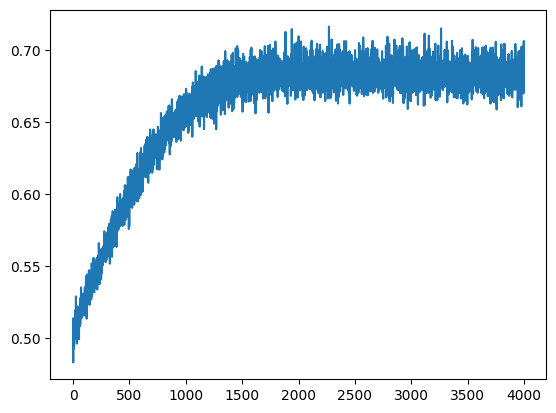

In [11]:
plt.plot(ode_time * d, adam_risk)

In [12]:
def phi_from_B(B, f, beta,  key, n_samples = 10000):
    """
    Compute the mean of the adam update in terms of B
    TODO: Document this better    
    """
    
    Binv = jnp.linalg.inv(B)
    key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)

    history_length = 50
    # Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
    Q = jax.random.multivariate_normal(key_Q, mean = np.zeros(2), cov = B, shape=(n_samples, 1))
    z = jax.random.normal(key_z, (n_samples))

    if beta > 0:
        Q_history = jax.random.multivariate_normal(key_Q_hist, mean = np.zeros(2), cov = B, shape=(n_samples, history_length))
        z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

        decay_vec = jnp.array([beta ** i for i in range(1, history_length + 1)])
        history_average = (1-beta)*(f(Q_history)**2 * z_history**2) @ decay_vec
    else:
        history_average = 0

    fq = f(Q)
    fq = fq.squeeze()
    Q = Q.squeeze()
    
    ter = jnp.sqrt( history_average + (1-beta) * fq**2 * z**2)
    ter = history_average + (1-beta) * fq**2 * z**2
    print(Q)
    # print(ter)
    # print(ter.shape)
    # print((z**2 * fq).shape)
    # ter2 =(z**2 * fq / jnp.sqrt( history_average + (1-beta) * fq**2 * z**2))
    # print('*' * 30)
    # print(ter2)
    # print(ter2.mean())
    term3 = (z**2 * fq / jnp.sqrt( history_average + (1-beta) * fq**2 * z**2))[:,None]  *  (Q @ Binv)
    # print(term3)
    phi = jnp.mean((z**2 * fq / jnp.sqrt( history_average + (1-beta) * fq**2 * z**2))[:,None]  *  (Q @ Binv), axis = 0)
        
    return phi


i = 30
s = phi_from_B(Bs[i],f_linreg, beta2, key)
jnp.linalg.inv(Bs[i])

[[-1.5470093  -1.0014733 ]
 [ 0.69226795  0.72686315]
 [ 0.8864087   0.53016406]
 ...
 [-0.6638168  -0.63450736]
 [-0.1926438  -0.20964368]
 [ 0.6149826   0.3792493 ]]


Array([[ 13.733393, -10.876118],
       [-10.876117,   9.514901]], dtype=float32)

In [13]:
print(Bs[i])
B = np.array(Bs[i])
B[1,0] = B[0,1]
np.random.multivariate_normal(mean = np.zeros(2), cov = B)

[[0.7684484  0.87838376]
 [0.87838376 1.1091449 ]]


array([-0.45814192, -0.13689063])

In [14]:
np.linalg.eigh(B)

EighResult(eigenvalues=array([0.04404723, 1.8335462 ], dtype=float32), eigenvectors=array([[-0.7714877 ,  0.63624424],
       [ 0.63624424,  0.7714877 ]], dtype=float32))

In [15]:
print(x0.T @ K @ x0)
print(x0.T @ K @ xstar)
print(xstar @ K @ x0)
print(xstar @ K @ xstar)

0.7550001
0.86877394
0.86877394
1.1091449
